# Оценка рабочего времени сотрудника по видеозаписи

Цели:

* Взять каждый 15 кадр из видео, вырезать картинку согласно координатам и сделать решейп на 116\*116.
* Рассортировать и сохранить данные в две папки: сотрудник на рабочем месте или нет.
* Обучить нейронную сеть (классификатор) на keras или pytorch.


Координаты выреза (ближний стол, на картинке левый):

* xmin,ymin = 115, 210
* xmax, ymax = 350, 445

# Импорт библиотек

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap as cmap

import os
import pickle
from tqdm import tqdm, notebook

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
sns.set_theme(context='paper',
              palette='muted',
              style='whitegrid',
              font_scale=1.1,)

plt.rcParams.update({'lines.linewidth': 1.25,
                     'grid.linewidth': 0.5,
                     'grid.alpha': 0.5,
                     'figure.constrained_layout.use': True,
                     'figure.figsize': (10, 6)})

%config InlineBackend.figure_format = 'retina'

In [3]:
# python -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


# Загрузка данных

In [4]:
# Путь к файлам.
root_path = r'C:\Users\igor_\Documents\cv_data'

# Размер картинки после решейпа.
width, height = 116, 116

# Координаты выреза.
xmin, ymin = 115, 210
xmax, ymax = 350, 445

# Кадр который нам нужен.
save_fps = 15

In [5]:
# Загрузим видео.
video_file = root_path + r'\cam_video.mp4'
cap = cv2.VideoCapture(video_file)

Найдем количество кадров в секунду, число фреймов и длительность видеофайла.

In [6]:
fps = cap.get(cv2.CAP_PROP_FPS)
fps

15.000817650291209

In [7]:
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
total_frames

565248

In [8]:
duration = total_frames // fps
duration

37681.0

In [9]:
# Проверка.
(success, img) = cap.read()

if success:
    cv2.imshow('cam_img', img)
    cv2.waitKey()

# Обработка

Выберем каждый 15 кадр и сохраним всё в images.

In [10]:
try:
    with open(root_path + r'\images.pickle', 'rb') as f:
        images = pickle.load(f)
except:
    images = []

    for i in notebook.tqdm(range(0, total_frames, 15)):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        (success, img) = cap.read()

        if not success:
            break

        # Для последующей классификации - перевод
        # в изображения к оттенкам серого.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Применяем гауссово размытие чтобы было легче найти контуры.
        img = cv2.GaussianBlur(img, (3, 3), 0)
        # Вырез области и решейп на 116*116.
        images.append(cv2.resize(img[ymin:ymax, xmin:xmax],
                                 (width, height),
                                 cv2.INTER_NEAREST))

    # Освобождение ресурсов.
    cap.release()
    cv2.destroyAllWindows()

    with open(root_path + r'\images.pickle', 'wb') as f:
        pickle.dump(images, f)

Определим насколько кадры в images отличаются от первого.

  0%|          | 0/37684 [00:00<?, ?it/s]

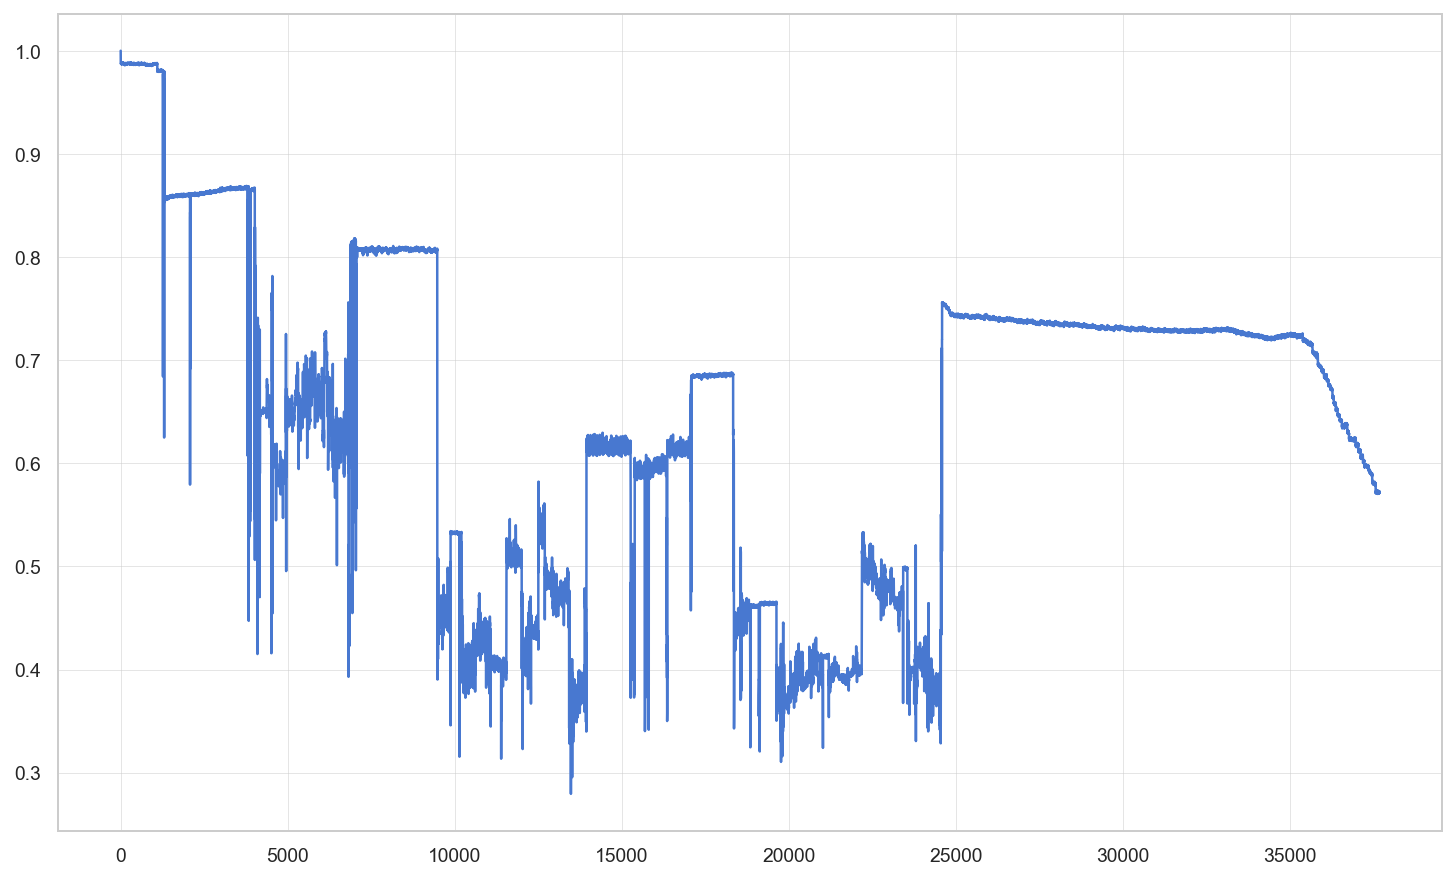

In [11]:
difference = []

for img in notebook.tqdm(images):
    difference.append(
        ssim(images[0], img, 
             gaussian_weights=True)
    )
    
sns.lineplot(data=difference);

Рассмотрим разницу между соседними метриками ssim чтобы найти кадры в которых на видео что-то происходит.

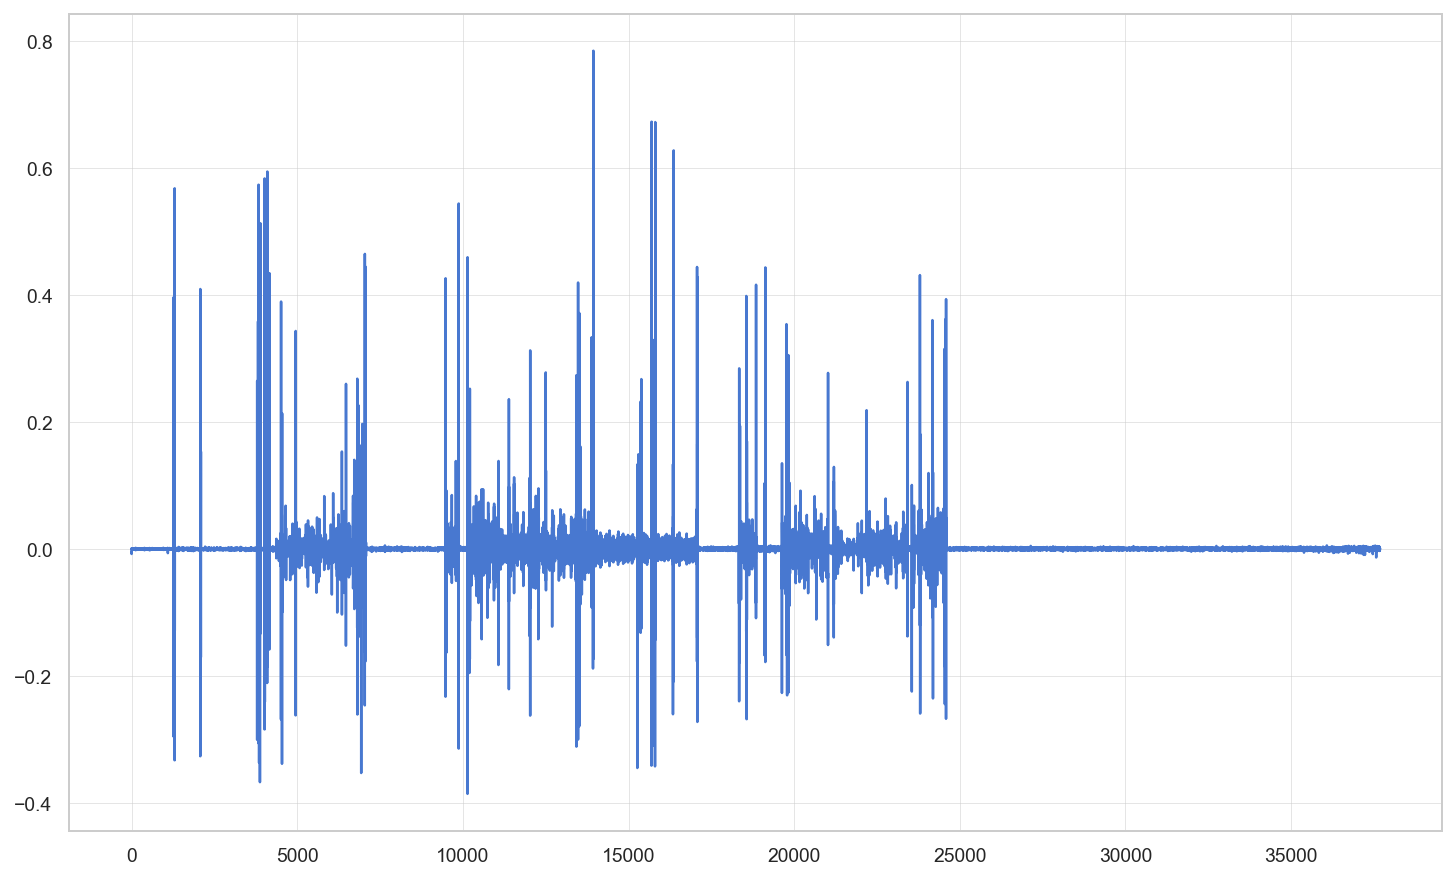

In [12]:
grad = [(x[1] - x[0]) / x[0] for x in zip(difference[:-1], difference[1:])]

sns.lineplot(data=grad);

In [13]:
# Округлим индекс и преобразуем результат для уменьшения количества просматриваемых вручную кадров.
rounder = 20

grad_rounded = sorted(list(
    set(
        map(lambda x: x // rounder * rounder,
            # Все изменения ниже порога считаем незначительными.
            [i for i in range(len(grad)) if grad[i] > 0.05])
    )
))

Посмотрим выбранные кадры.

In [ ]:
max_img_index = len(images) - 1

for i in range(len(grad_rounded) // 4 + (len(grad_rounded) % 4 != 0)):
    fig, axes = plt.subplots(1, 4, sharex=True, sharey=True,
                             figsize=(12,12))
    try:
        for j in range(4):
            axes[j].imshow(X=images[grad_rounded[j + i * 4]], cmap=plt.cm.gray)
            axes[j].set_xticks([])
            axes[j].set_yticks([])
            axes[j].set_xlabel(f'Кадр № {grad_rounded[j + i * 4]} / {max_img_index}')
            axes[j].grid(False)
    except:
        # Так как число элементов может быть не кратно 4, нужен блок except.
        for k in range(j, 4):
            axes[k].imshow(X=images[max_img_index], cmap=cmap(['black']))
            axes[k].set_xticks([])
            axes[k].set_yticks([])
            axes[k].set_xlabel('Кадр - заглушка')
            axes[k].grid(False)
        
    plt.show()

Проанализируем полученные снимки и найдем временные диапазоны когда сотрудник был за компьютером.

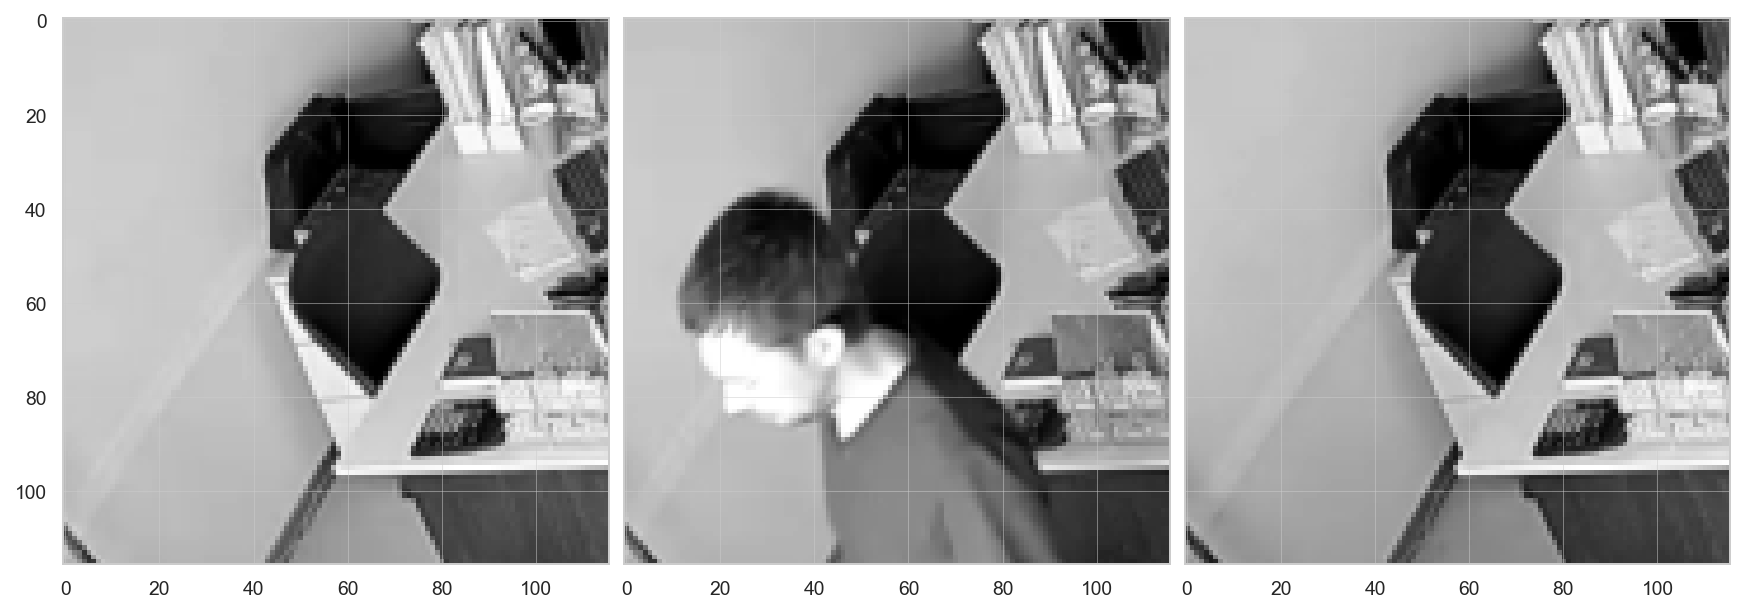

In [15]:
с = 1266

fig, axes = plt.subplots(1, 3, sharex=True, sharey=True,
                         figsize=(12,12))
axes[0].imshow(X=images[с-10], cmap=plt.cm.gray)
axes[1].imshow(X=images[с], cmap=plt.cm.gray)
axes[2].imshow(X=images[с+10], cmap=plt.cm.gray);

In [16]:
is_working = [
    (9486, 9871),
    (10215, 11074),
    (11394, 12005),
    (12036, 13424),
    (13481, 13512),
    (13549, 13885),
    (18365, 18552),
    (18570, 18845),
    (19636, 19766),
    (19840, 21020),
    (21200, 23419),
    (23555, 23794),
    (23808, 24171),
    (24195, 24534)
]

is_working_index = []
for diapason in is_working:
    is_working_index.extend(
        list(range(diapason[0], diapason[1] + 1))
    )

# Количество кадров в которых сотрудник находится за столом.
len(is_working_index)

8556

In [17]:
# Создаем папки на случай если их нет.
os.makedirs(os.path.dirname(root_path + '/images/working/'), exist_ok=True)
os.makedirs(os.path.dirname(root_path + '/images/not_working/'), exist_ok=True)

for i in range(len(images)):
    if i in is_working_index:
        path = root_path + fr'\images\working\frame_{i}.jpg'
    else:
        path = root_path + fr'\images\not_working\frame_{i}.jpg'
    cv2.imwrite(path, images[i])

# Предсказание в TensorFlow / Keras

Создадим датасеты.

In [18]:
image_size = (width, height)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    root_path + r'\images',
    validation_split=0.2,
    subset="training",
    seed=38,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    root_path + r'\images',
    validation_split=0.2,
    subset="validation",
    seed=38,
    image_size=image_size,
    batch_size=batch_size,
)

Found 37684 files belonging to 2 classes.
Using 30148 files for training.
Found 37684 files belonging to 2 classes.
Using 7536 files for validation.


Добавим RandomFlip, это поможет избежать переобучения.

In [19]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.1),
    ]
)

In [20]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## Построение модели

Модель основана на упрощенной нейросети Xception.

Гиперпараметры не подбирались, можно было использовать KerasTuner.

In [21]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block.
    x = layers.Rescaling(1.0 / 255)(x) # Стандартизируем данные.
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # for size in [128, 256, 512, 728]:
    size = 128
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # Project residual
    residual = layers.Conv2D(size, 1, strides=2, padding="same")(
        previous_block_activation
    )
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        # Потенциально можно свести задачу к мультклассу, добавив
        # отдельный класс на случай когда люди загораживают камеру.
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=2)

## Тренировка и валидация модели

In [22]:
epochs = 5

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, validation_data=val_ds,
)

Epoch 1/5
943/943 [==============================] - 49s 49ms/step - loss: 0.0251 - accuracy: 0.9928 - val_loss: 0.4971 - val_accuracy: 0.8004
Epoch 2/5
943/943 [==============================] - 46s 48ms/step - loss: 0.0115 - accuracy: 0.9969 - val_loss: 0.0074 - val_accuracy: 0.9976
Epoch 3/5
943/943 [==============================] - 46s 49ms/step - loss: 0.0097 - accuracy: 0.9978 - val_loss: 0.1795 - val_accuracy: 0.9424
Epoch 4/5
943/943 [==============================] - 46s 48ms/step - loss: 0.0074 - accuracy: 0.9981 - val_loss: 0.0226 - val_accuracy: 0.9951
Epoch 5/5
943/943 [==============================] - 46s 49ms/step - loss: 0.0071 - accuracy: 0.9982 - val_loss: 0.0038 - val_accuracy: 0.9992


## Проверка модели

In [23]:
def img_prediction(img_index):
    cap.set(cv2.CAP_PROP_POS_FRAMES, img_index)

    _, img = cap.read()
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img[ymin:ymax, xmin:xmax],
                     (width, height),
                     cv2.INTER_NEAREST)

    img_array = tf.expand_dims(img, 0)
    predictions = model.predict(img_array)
    score = predictions[0]

    print()
    print(
        f'На рабочем месте никого нет\t{1 - score[0]:.2%}.',
        f'Сотрудник находится за столом\t{score[0]:.2%}.', sep='\n'
    )

    plt.imshow(X=img);

Посторонний в кадре.

1/1 [==============================] - 0s 143ms/step

На рабочем месте никого нет	100.00%.
Сотрудник находится за столом	0.00%.


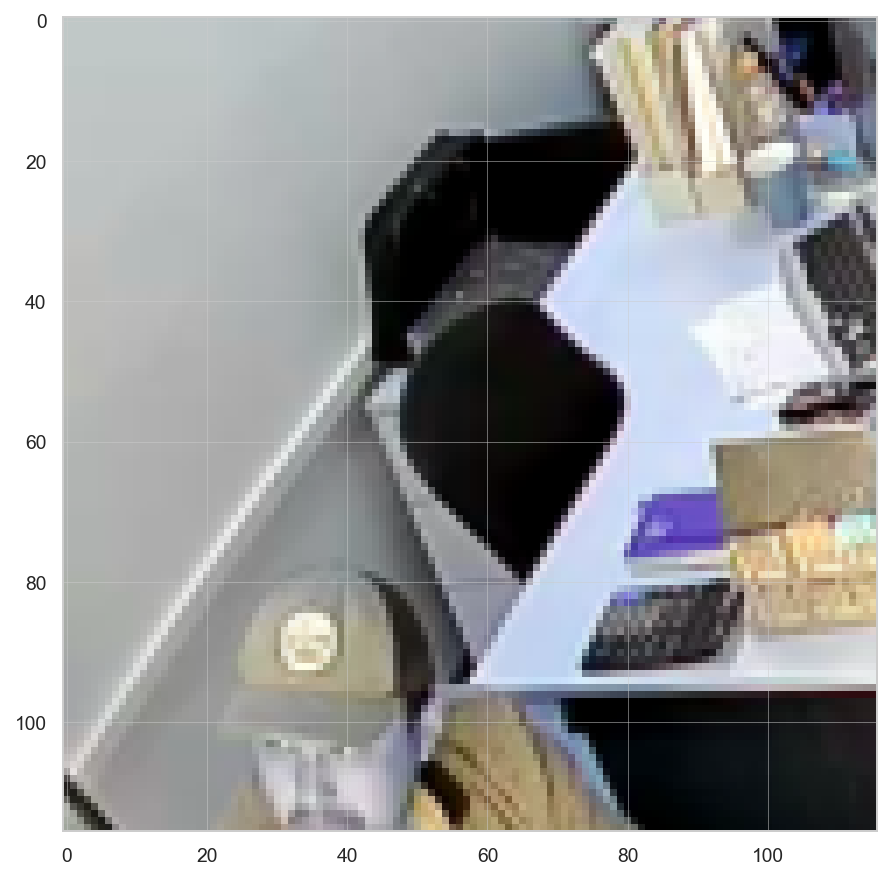

In [24]:
img_prediction(4500*15 - 5)

Рабочее место пустует.

1/1 [==============================] - 0s 16ms/step

На рабочем месте никого нет	100.00%.
Сотрудник находится за столом	0.00%.


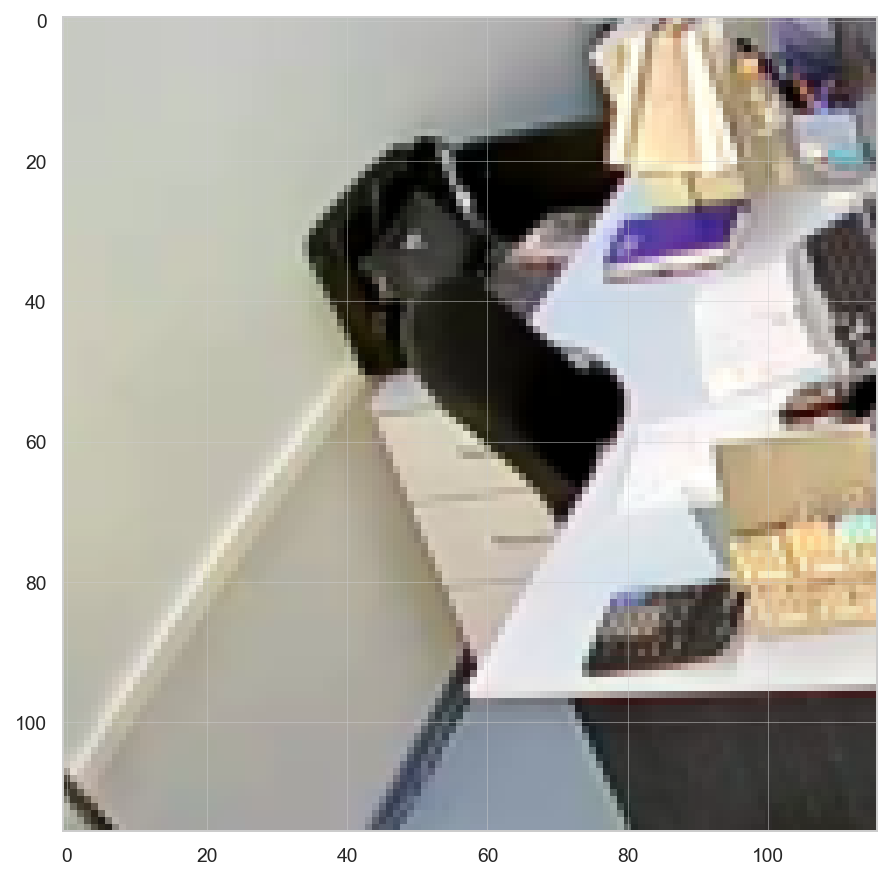

In [25]:
img_prediction(16000*15 - 5)

Сотрудник сидит за столом на рабочем месте.

1/1 [==============================] - 0s 17ms/step

На рабочем месте никого нет	0.00%.
Сотрудник находится за столом	100.00%.


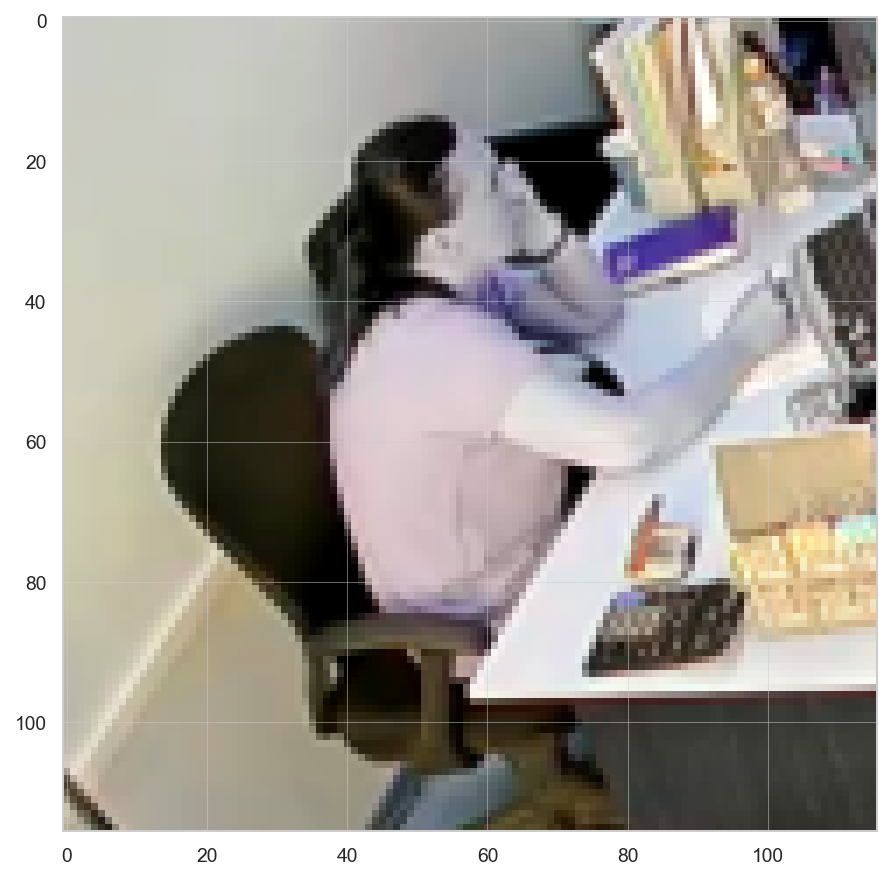

In [26]:
img_prediction(20500*15 - 5)

Сохраним модель

model.save(root_path +'/model.h5')